In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files
# under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Setup plotting
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('animation', html='html5')

In [3]:
#import libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GroupShuffleSplit

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks

In [4]:
#load data sets
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv", index_col=0)
train_data = train_data.drop(['Name','Cabin','HomePlanet'], axis=1)
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv", index_col=0)
test_data = test_data.drop(['Name','Cabin','HomePlanet'], axis=1)
#-------------------------------------------------------------------------------#
print("Summary of the DataFrame:")
#uncomment to check data
print(train_data.info())
train_data.head()
#check
#test_data.head()

Summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 8693 entries, 0001_01 to 9280_02
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CryoSleep     8476 non-null   object 
 1   Destination   8511 non-null   object 
 2   Age           8514 non-null   float64
 3   VIP           8490 non-null   object 
 4   RoomService   8512 non-null   float64
 5   FoodCourt     8510 non-null   float64
 6   ShoppingMall  8485 non-null   float64
 7   Spa           8510 non-null   float64
 8   VRDeck        8505 non-null   float64
 9   Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(3)
memory usage: 687.6+ KB
None


,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
PassengerId,,,,,,,,,,
0001_01,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False
0002_01,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True
0003_01,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False
0003_02,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False
0004_01,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True


In [5]:
#map({'False': 0, 'True': 1}
Y = train_data['Transported']
Y=Y.replace({False: 0, True: 1})
#check
#print(Y)

In [6]:
#preprocessing data
# 1. replace null values
#seperate numerical and caterogical featuers
X = train_data.drop(['Transported'], axis =1)
X_num = X.select_dtypes(include=np.number).copy()
X_cat = X.select_dtypes(include= 'object').copy()
test_num = test_data.select_dtypes(include=np.number).copy()
test_cat = test_data.select_dtypes(include= 'object').copy()
#----------------------------------------------------------------------------------#
#replace missing vlues with mean(numeric) or most recuurent(caterogical)
X_num = X_num.fillna(X_num.mean())
test_num = test_num.fillna(test_num.mean())
X_cat = X_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
test_cat = test_cat.apply(lambda x: x.fillna(x.value_counts().index[0]))
#----------------------------------------------------------------------------------#
# Apply ordinal encoder to catoricical featuers  
OHE = OneHotEncoder()
X_cat_OH = OHE.fit_transform(X_cat).toarray()
test_cat_OH = OHE.fit_transform(test_cat).toarray()
#---------------------------------------------------------------------------------#
#check
print(X_num.shape)
print(X_cat_OH.shape)
# joint datasets
Xf = np.concatenate((X_num, X_cat_OH), axis=1)
testf = np.concatenate((test_num, test_cat_OH), axis=1)
# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(Xf, Y, train_size=0.8,test_size=0.2, random_state=1)

(8693, 6)
(8693, 7)


In [7]:
input_shape = [train_X.shape[1]]
print("Input shape: {}".format(input_shape))
loss= keras.losses.BinaryCrossentropy(from_logits= False)
#model
model =  keras.Sequential([
    layers.BatchNormalization(input_shape= input_shape ),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),    
    layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=['accuracy'],
)

Input shape: [13]


<AxesSubplot:title={'center':'Accuracy'}>

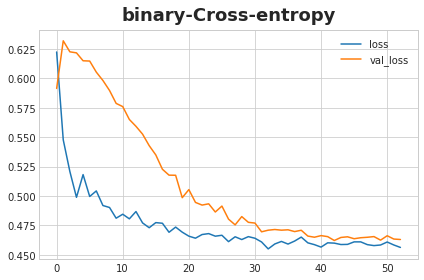

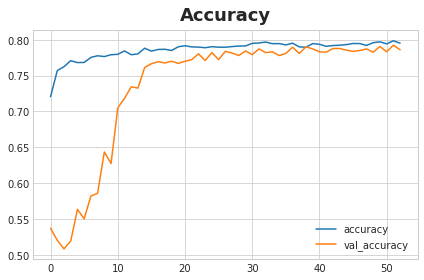

In [8]:
#training
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="binary-Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [9]:
predictions = model.predict(testf)
predicted = np.array([True if x >= 0.5 else False for x in predictions])
output = pd.DataFrame({"Id":test_data.index, "target":predicted})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
